# An Improved KNN Based on Class Contribution and Feature Weighting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import operator

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statistics import mean
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
# Define k-fold yang diujikan disini :
K_yang_diujikan = [3, 5, 10, 20, 30]

In [3]:
#fungsi buat dapetin jarak eucledian
#data1 = data pertama
#data2 = data pembanding
#length = jumlah variabel yang dibandingkan
def eucledianDistance(data1, data2, length, weight=[1,1,1,1,1,1,1,1,1,1,1,1]):
    distance = 0
    for x in range(length):
        distance += (weight[x]*pow((float(data1[x]) - float(data2[x])), 2))
        # print(str(data1) + "-" + str(data2) + ": " + str(distance))
    return math.sqrt(distance)

In [4]:
#fungsi untuk mendapatkan tetangga terdekat
#trainingset = data training / ground truth
#testdata = data testing / data yang diuji
#k = tetangga
def getNeighbors(trainingSet, testData, testClass, k, weight=[1,1,1,1,1,1,1,1,1,1,1,1]):
    #array distance untuk nyimpan jarak, nanti akan disort yang tedekat
    # print(len(testData))
    distance = []
    length = len(testData) - 1
    for x in range(len(trainingSet)):
        dist = eucledianDistance(testData, trainingSet[x], length)
        distance.append((trainingSet[x], testClass[x], dist))
        # print((trainingSet[x], dist))
    distance.sort(key=operator.itemgetter(2))
    #print(distance)
    neighbors = []
    for x in range(k):
        #habis disort, data tetangga terdekat disimpan di array neighbors
        neighbors.append(distance[x][0:2])
#     print(neighbors)
    return neighbors

In [5]:
def getNeighborsDCT(trainingSet, testData, testClass, k, weight):
    #array distance untuk nyimpan jarak, nanti akan disort yang tedekat
    # print(len(testData))
    distance = []
    length = len(testData) - 1
    for x in range(len(trainingSet)):
        dist = eucledianDistance(testData, trainingSet[x], length, weight)
        distance.append((trainingSet[x], testClass[x], dist))
        # print((trainingSet[x], dist))
    distance.sort(key=operator.itemgetter(2))
    # print(distance)
    neighbors = []
    for x in range(k):
        #habis disort, data tetangga terdekat disimpan di array neighbors
        neighbors.append(distance[x][0:3])
    # print(neighbors)
    return neighbors

In [6]:
#fungsi getResponse buat nyari datatest masuk kelas mana / voting kelasnya
def getResponse(neighbors):
    #classvote disiapin buat penampung proses voting kelas
    classVote = {}
    # print(neighbors)
    for x in range(len(neighbors)):
#         print(neighbors[x][-1])
#         print(type(neighbors[x]))
        response = neighbors[x][-1]
        # print(response)
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
    # print(classVote)
    # sortedVotes buat milih vote kelas terbanyak
#     print("classVote")
#     print(classVote)
    sortedVotes = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    # print(sortedVotes[0][0])
    return sortedVotes[0][0]

In [7]:
def getResponseDCT(neighbors):
    #classvote disiapin buat penampung proses voting kelas
    classVote = {}
    sumDistance = {}
    # print(neighbors)
    for x in range(len(neighbors)):
#         print(neighbors[x][-1])
#         print(type(neighbors[x]))
        response = neighbors[x][-2]
        # print(response)
        if response in classVote:
            classVote[response] += 1
            sumDistance[response] += neighbors[x][-1]
        else:
            classVote[response] = 1
            sumDistance[response] = neighbors[x][-1]
    # print(classVote)
    # sortedVotes buat milih vote kelas terbanyak
#     sortedVotes = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    # print(sortedVotes[0][0])
    
    return classVote, sumDistance

In [8]:
def KNN(KF_xtrain, KF_xtest, KF_ytrain, numberofNeighbour, weight=[1,1,1,1,1,1,1,1,1,1,1,1]):
    neighbors = getNeighbors(KF_xtrain, KF_xtest, KF_ytrain, numberofNeighbour)
    result = getResponse(neighbors)
    neighbors.clear()
    return result

In [9]:
def DCT_KNN(KF_xtrain, KF_xtest, KF_ytrain, numberofNeighbour, weight):
    neighbors = getNeighborsDCT(KF_xtrain, KF_xtest, KF_ytrain, numberofNeighbour, weight)
    classVote, sumDistance = getResponseDCT(neighbors)
    CT = []
#     print(classVote, sumDistance)
    for x in (classVote):
        CT.append((numberofNeighbour/classVote[x])+((1/classVote[x])*sumDistance[x]))
#     print(CT)
#     print(list(classVote.keys())[CT.index(min(CT))])
    return list(classVote.keys())[CT.index(min(CT))]

In [10]:
#fungsi getKFold untuk melakukan operasi K-Fold dan return accuracy
def getKFold(dataX, dataY, numberofK, numberofNeighbour, method, weight=[1,1,1,1,1,1,1,1,1,1,1,1]):    
    prediction = []
    fold = 1
    KF_xtrain = []
    KF_xtest = []
    KF_ytrain = []
    KF_ytest = []
    knn_accuracy = []
    knn_f1 = []
    kfold = KFold(n_splits=numberofK, shuffle=True, random_state=True)
    for train, test in kfold.split(dataX, dataY):
        # print('train: %s, test: %s' % (X[train], X[test]))
        KF_xtrain.append(dataX[train])
        KF_xtest.append(dataX[test])
        KF_ytrain.append(dataY[train])
        KF_ytest.append(dataY[test])
        for j in range(len(KF_xtest[0])):
            if method == "KNN":
                prediction.append(KNN(KF_xtrain[0], KF_xtest[0][j], KF_ytrain[0], numberofNeighbour))
            elif method == "DCT-KNN":
                prediction.append(DCT_KNN(KF_xtrain[0], KF_xtest[0][j], KF_ytrain[0], numberofNeighbour, weight))
        knn_f1.append(f1_score(KF_ytest[0], prediction, average='macro'))
        knn_accuracy.append(accuracy_score(KF_ytest[0], prediction))
        prediction.clear()
        # print(y_test)
        # print(prediction)
        fold += 1
        KF_xtest.clear()
        KF_xtrain.clear()
        KF_ytest.clear()
        KF_ytrain.clear()
#     print('K = ' + str(numberofK) + ' Neighbour = ' + str(numberofNeighbour)+ \
#           ' Accuracy: ' + str(mean(knn_accuracy)) + ' F1: ' + str(mean(knn_f1)))
    return ((mean(knn_accuracy)),(mean(knn_f1)));
    

In [11]:
namesIris = [
    'sepal-length',
    'sepal-width',
    'petal-width',
    'petal-length',
    'class'
]

nameTransfusion = [
    'Recency',
    'Frequency',
    'Monetary',
    'Time',
    'Yes/No Donate'
]

nameBupa = [
    'mcv',
    'alkphos',
    'sgpt',
    'sgot',
    'gammagt',
    'drinks',
    'selector'
]

## Iris Dataset

In [12]:
#Load dataset
path = "dataset/iris.data"
# path = "dataset/transfusion.data"
# path = "dataset/bupa.data"

In [13]:
dataset = pd.read_csv(path, header=None)
print(len(dataset))

150


In [14]:
##Dataset preprocessing
#membagi jadi 2, X untuk nilai numerik, Y untuk nama kelas
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values
Z_0 = np.delete(X, 0, 1)
Z_1 = np.delete(X, 1, 1)
Z_2 = np.delete(X, 2, 1)
Z_3 = np.delete(X, 3, 1)
#print(X)
#print(Z)

In [15]:
# 1. Delete one feature
# pret is the sum average accuracy of
# the traditional kNN algorithm in the original dataset when
# the value of k is 3,5 and 7 on the condition of 5-folder cross
# validation, and the prei is the similar sum of the traditional
# kNN algorithm on the data lacking the i-th feature.
normal_KNN_result = []
lack_feature_result = defaultdict(list)
z = {}

for N in (3, 5, 7):
    (normal_result, dummy) = getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="KNN")
    normal_KNN_result.append(normal_result)
    for k in range (4):
        (lack_result, dummy) = getKFold(locals()["Z_" + str(k)], Y, numberofK=5, numberofNeighbour=N, method="KNN")
        lack_feature_result[k].append(lack_result)
        
# print(normal_KNN_result)
# for k in range (4):
#     print(lack_feature_result[k])

In [16]:
disc = []
for i in range (4):
    disc.append((1-(sum(lack_feature_result[i]) - sum(normal_KNN_result))))
# print(disc)
normalized_disc = []
for i in range (4):
    normalized_disc.append((disc[i]/sum(disc)))
print(normalized_disc)

[0.19176319176319173, 0.18790218790218788, 0.31016731016731025, 0.31016731016731025]


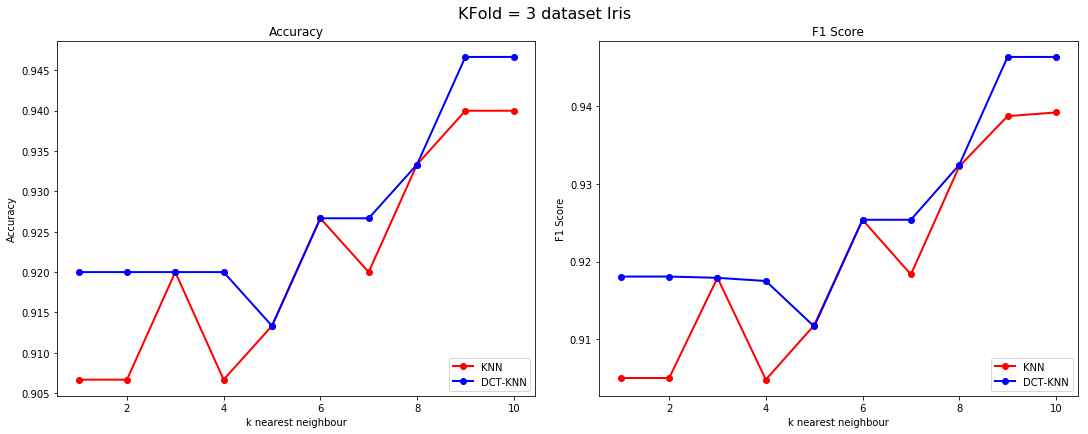

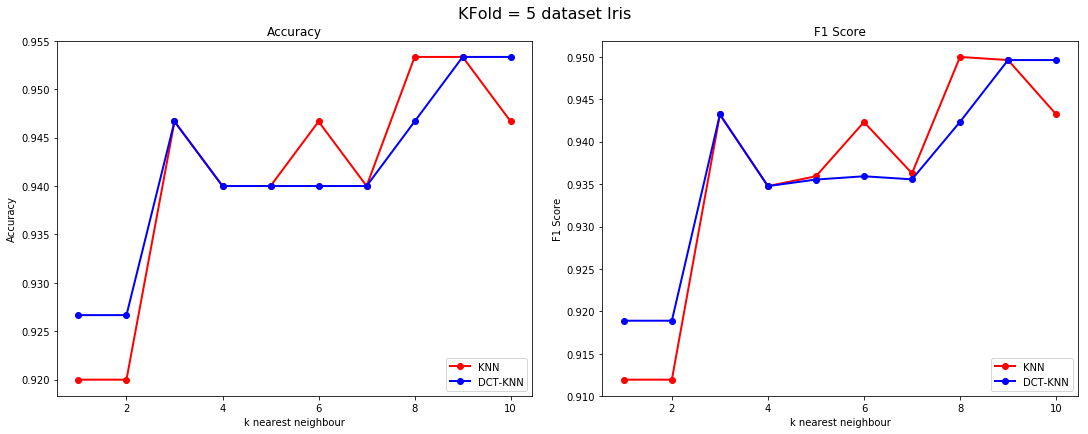

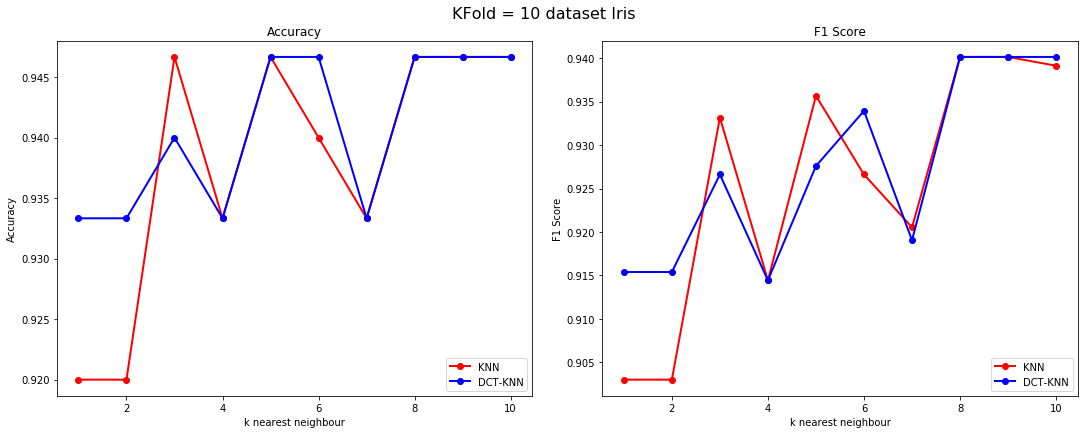

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


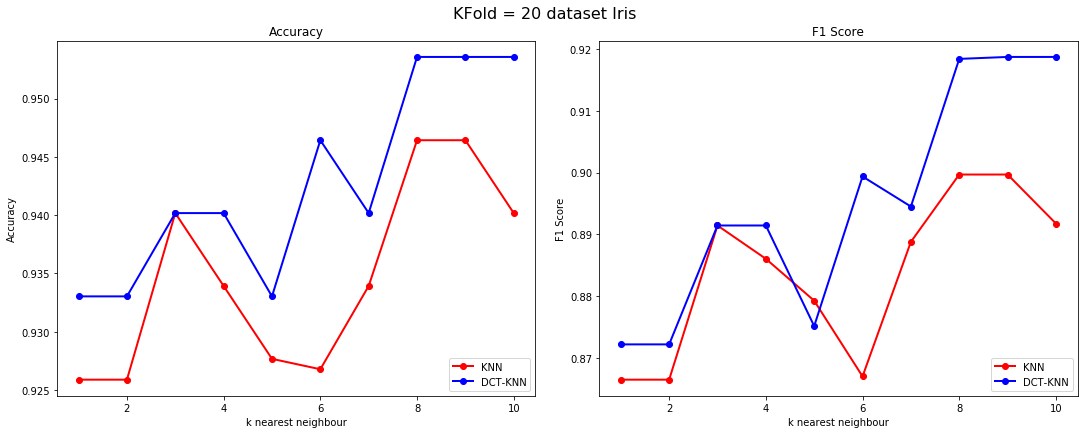

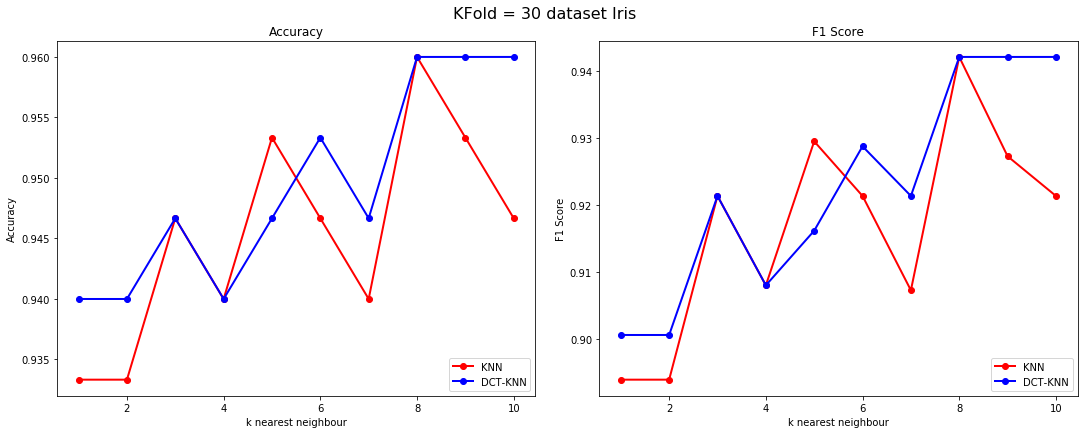

In [17]:
for K in K_yang_diujikan:
    KNN_accuracy_list = []
    KNN_f1_list = []
    DCTKNN_accuracy_list = []
    DCTKNN_f1_list = []
    pltplotvar = []
    
    for N in range (1, 11):
        knn_acc, knn_f1 = getKFold(X, Y, numberofK=K, numberofNeighbour=N, method="KNN")
        KNN_accuracy_list.append(knn_acc)
        KNN_f1_list.append(knn_f1)
        DCTKNN_acc,DCTKNN_f1 = getKFold(X, Y, numberofK=K, numberofNeighbour=N, method="DCT-KNN", weight = normalized_disc)
        DCTKNN_accuracy_list.append(DCTKNN_acc)
        DCTKNN_f1_list.append(DCTKNN_f1)
        pltplotvar.append(N)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
    fig.suptitle('KFold = ' + str(K) + ' dataset Iris', fontsize=16)
    
    axs[0].plot(pltplotvar,KNN_accuracy_list,'-ro', label="KNN", linewidth=2.0)
    axs[0].plot(pltplotvar,DCTKNN_accuracy_list,'-bo', label="DCT-KNN", linewidth=2.0)
    axs[0].legend(loc='lower right')
    axs[0].set_xlabel('k nearest neighbour')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Accuracy')
    
    axs[1].plot(pltplotvar,KNN_f1_list,'-ro', label="KNN", linewidth=2.0)
    axs[1].plot(pltplotvar,DCTKNN_f1_list,'-bo', label="DCT-KNN", linewidth=2.0)
    axs[1].legend(loc='lower right')
    axs[1].set_xlabel('k nearest neighbour')
    axs[1].set_ylabel('F1 Score')
    axs[1].set_title('F1 Score')
    
    plt.show()


## Blood Dataset

In [18]:
#Load dataset
# path = "dataset/iris.data"
path = "dataset/transfusion.data"
# path = "dataset/bupa.data"

In [19]:
dataset = pd.read_csv(path, header=None)
print(len(dataset))

748


In [20]:
##Dataset preprocessing
#membagi jadi 2, X untuk nilai numerik, Y untuk nama kelas
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values
Z_0 = np.delete(X, 0, 1)
Z_1 = np.delete(X, 1, 1)
Z_2 = np.delete(X, 2, 1)
Z_3 = np.delete(X, 3, 1)
#print(X)
#print(Z)

In [21]:
# 1. Delete one feature
# pret is the sum average accuracy of
# the traditional kNN algorithm in the original dataset when
# the value of k is 3,5 and 7 on the condition of 5-folder cross
# validation, and the prei is the similar sum of the traditional
# kNN algorithm on the data lacking the i-th feature.
normal_KNN_result = []
lack_feature_result = defaultdict(list)
z = {}

for N in (3, 5, 7):
    (normal_result, dummy) = getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="KNN")
    normal_KNN_result.append(normal_result)
    for k in range (4):
        (lack_result, dummy) = getKFold(locals()["Z_" + str(k)], Y, numberofK=5, numberofNeighbour=N, method="KNN")
        lack_feature_result[k].append(lack_result)
        
# print(normal_KNN_result)
# for k in range (4):
#     print(lack_feature_result[k])

In [22]:
disc = []
for i in range (4):
    disc.append((1-(sum(lack_feature_result[i]) - sum(normal_KNN_result))))
# print(disc)
normalized_disc = []
for i in range (4):
    normalized_disc.append((disc[i]/sum(disc)))
print(normalized_disc)

[0.31886728841289247, 0.23113819271650976, 0.22499725943529889, 0.22499725943529889]


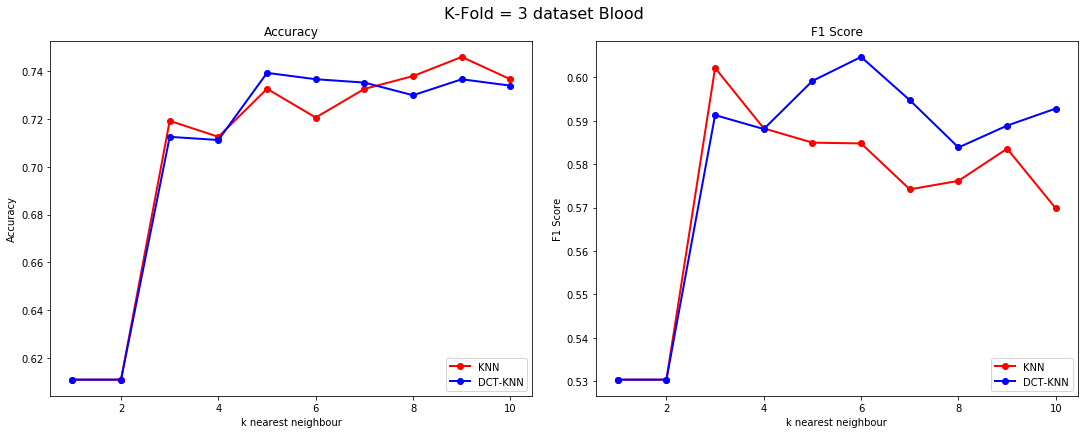

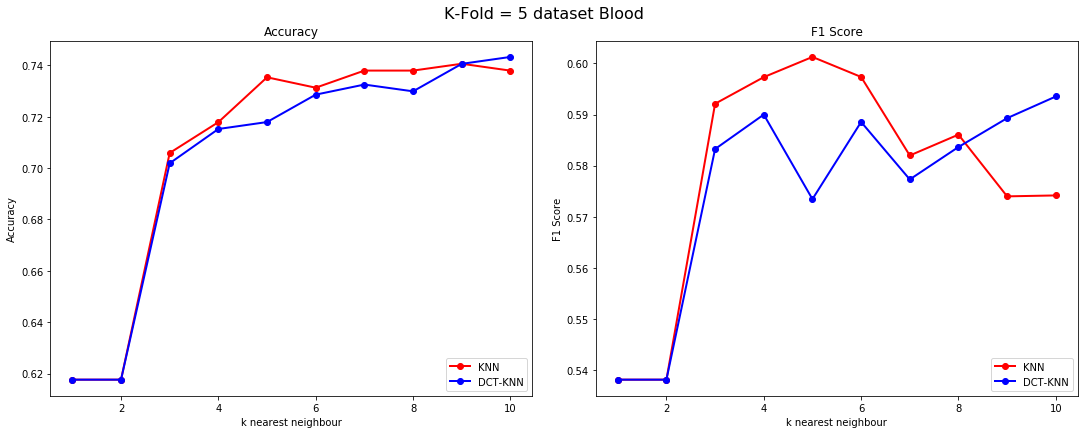

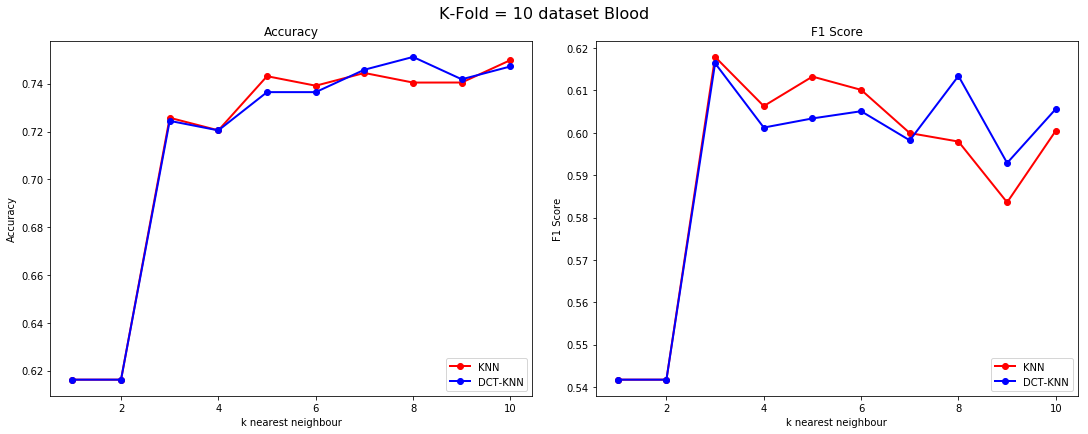

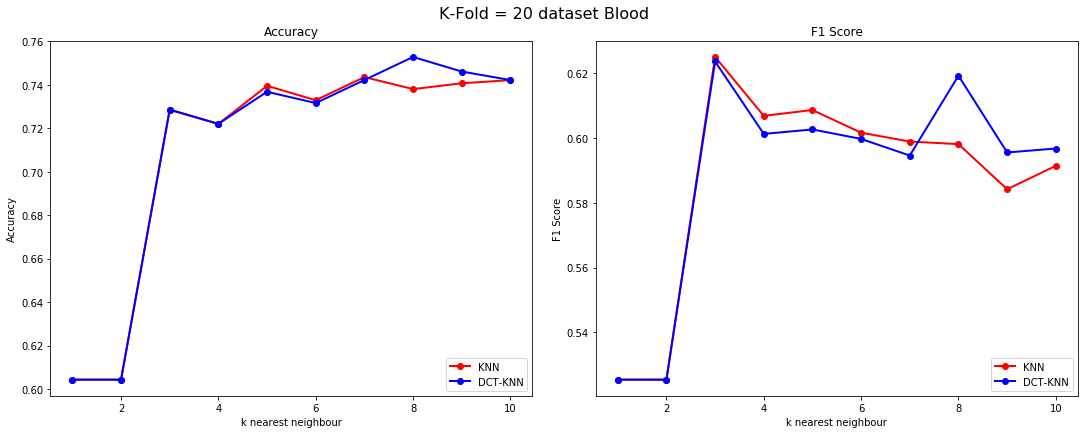

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


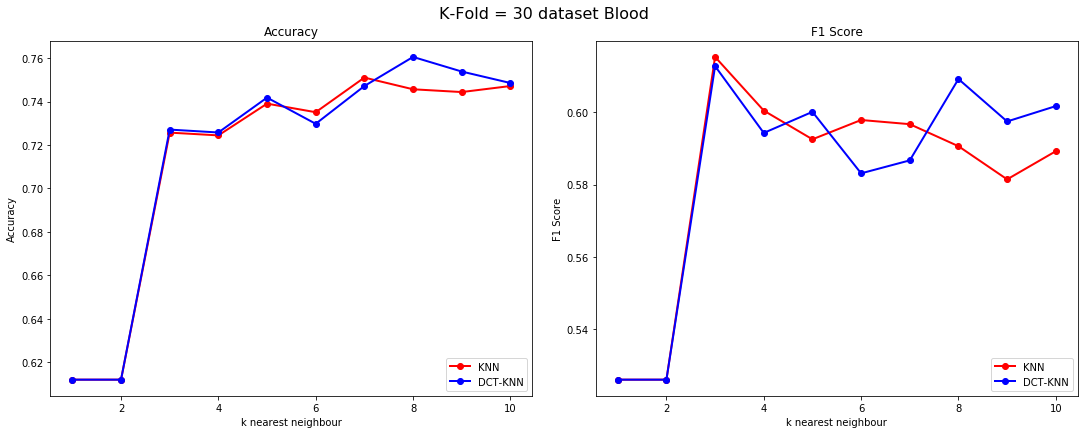

In [23]:
for K in K_yang_diujikan:
    KNN_accuracy_list = []
    KNN_f1_list = []
    DCTKNN_accuracy_list = []
    DCTKNN_f1_list = []
    pltplotvar = []
    
    for N in range (1, 11):
        knn_acc, knn_f1 = getKFold(X, Y, numberofK=K, numberofNeighbour=N, method="KNN")
        KNN_accuracy_list.append(knn_acc)
        KNN_f1_list.append(knn_f1)
        DCTKNN_acc,DCTKNN_f1 = getKFold(X, Y, numberofK=K, numberofNeighbour=N, method="DCT-KNN", weight = normalized_disc)
        DCTKNN_accuracy_list.append(DCTKNN_acc)
        DCTKNN_f1_list.append(DCTKNN_f1)
        pltplotvar.append(N)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
    fig.suptitle('K-Fold = ' + str(K) + ' dataset Blood', fontsize=16)
    
    axs[0].plot(pltplotvar,KNN_accuracy_list,'-ro', label="KNN", linewidth=2.0)
    axs[0].plot(pltplotvar,DCTKNN_accuracy_list,'-bo', label="DCT-KNN", linewidth=2.0)
    axs[0].legend(loc='lower right')
    axs[0].set_xlabel('k nearest neighbour')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Accuracy')
    
    axs[1].plot(pltplotvar,KNN_f1_list,'-ro', label="KNN", linewidth=2.0)
    axs[1].plot(pltplotvar,DCTKNN_f1_list,'-bo', label="DCT-KNN", linewidth=2.0)
    axs[1].legend(loc='lower right')
    axs[1].set_xlabel('k nearest neighbour')
    axs[1].set_ylabel('F1 Score')
    axs[1].set_title('F1 Score')
    
    plt.show()


## Liver Dataset

In [24]:
#Load dataset
# path = "dataset/iris.data"
# path = "dataset/transfusion.data"
path = "dataset/bupa.data"

In [25]:
dataset = pd.read_csv(path, header=None)
print(len(dataset))

345


In [26]:
##Dataset preprocessing
#membagi jadi 2, X untuk nilai numerik, Y untuk nama kelas
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values
Z_0 = np.delete(X, 0, 1)
Z_1 = np.delete(X, 1, 1)
Z_2 = np.delete(X, 2, 1)
Z_3 = np.delete(X, 3, 1)
Z_4 = np.delete(X, 4, 1)
Z_5 = np.delete(X, 5, 1)
#print(X)
#print(Z)

In [27]:
# 1. Delete one feature
# pret is the sum average accuracy of
# the traditional kNN algorithm in the original dataset when
# the value of k is 3,5 and 7 on the condition of 5-folder cross
# validation, and the prei is the similar sum of the traditional
# kNN algorithm on the data lacking the i-th feature.
normal_KNN_result = []
lack_feature_result = defaultdict(list)
z = {}

for N in (3, 5, 7):
    (normal_result, dummy) = getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="KNN")
    normal_KNN_result.append(normal_result)
    for k in range (6):
        (lack_result, dummy) = getKFold(locals()["Z_" + str(k)], Y, numberofK=5, numberofNeighbour=N, method="KNN")
        lack_feature_result[k].append(lack_result)
        
# print(normal_KNN_result)
# for k in range (4):
#     print(lack_feature_result[k])

In [28]:
disc = []
for i in range (6):
    disc.append((1-(sum(lack_feature_result[i]) - sum(normal_KNN_result))))
# print(disc)
normalized_disc = []
for i in range (6):
    normalized_disc.append((disc[i]/sum(disc)))
print(normalized_disc)

[0.16137684398748325, 0.15556548949485918, 0.17702279839070184, 0.15824765310683953, 0.17389360751005808, 0.17389360751005808]


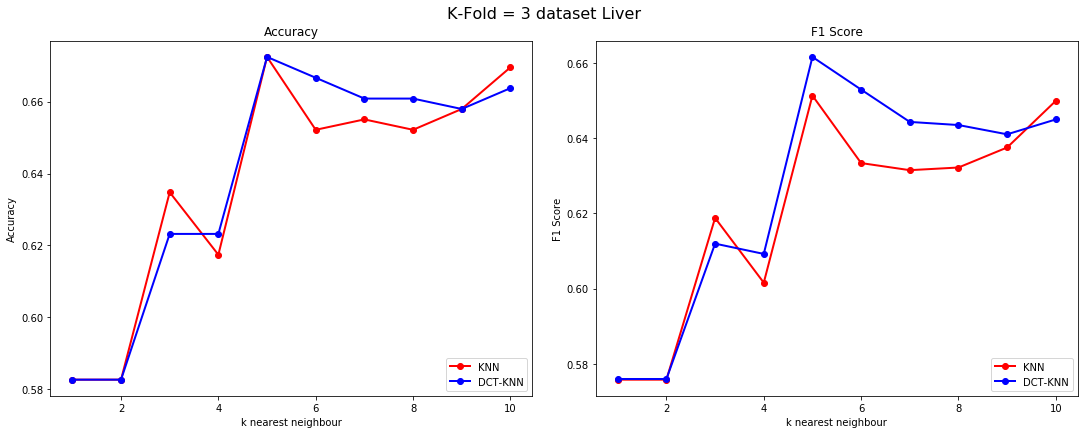

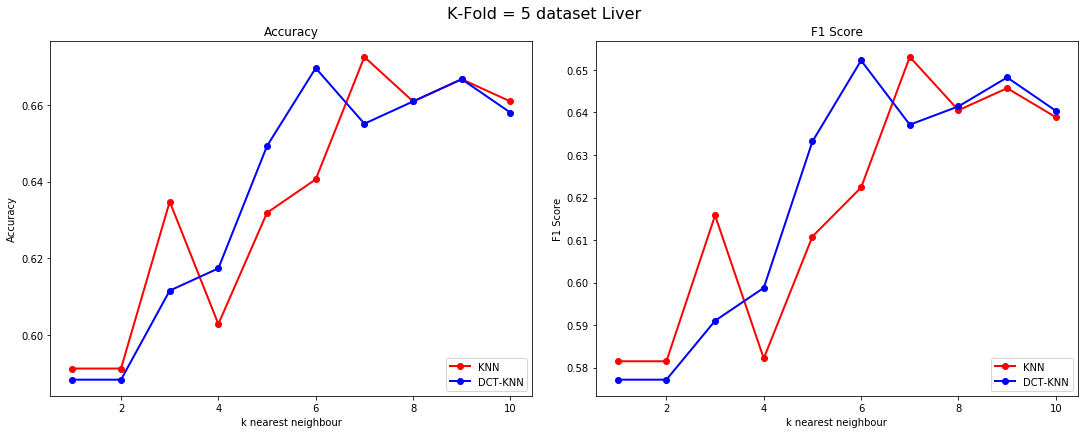

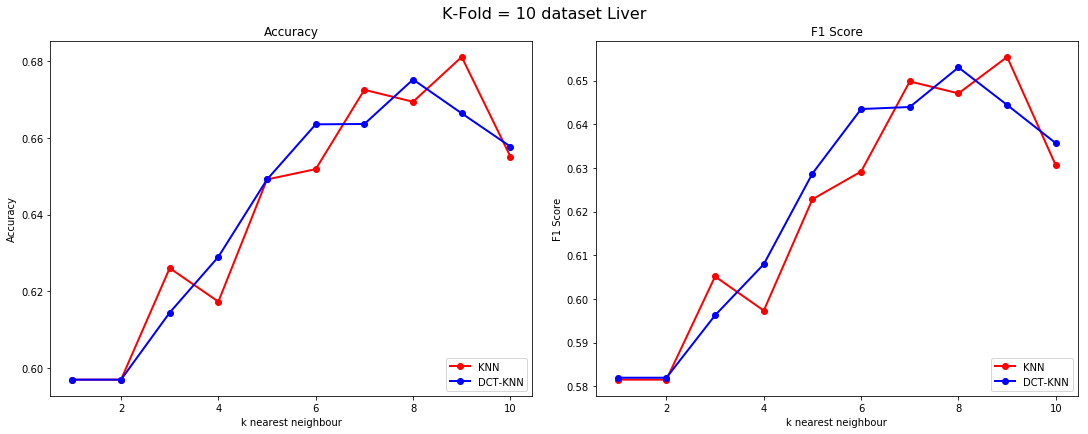

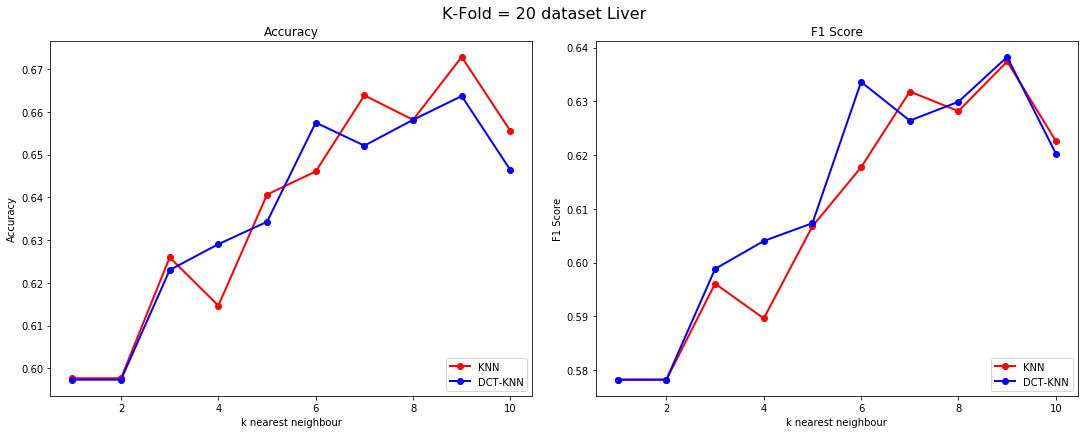

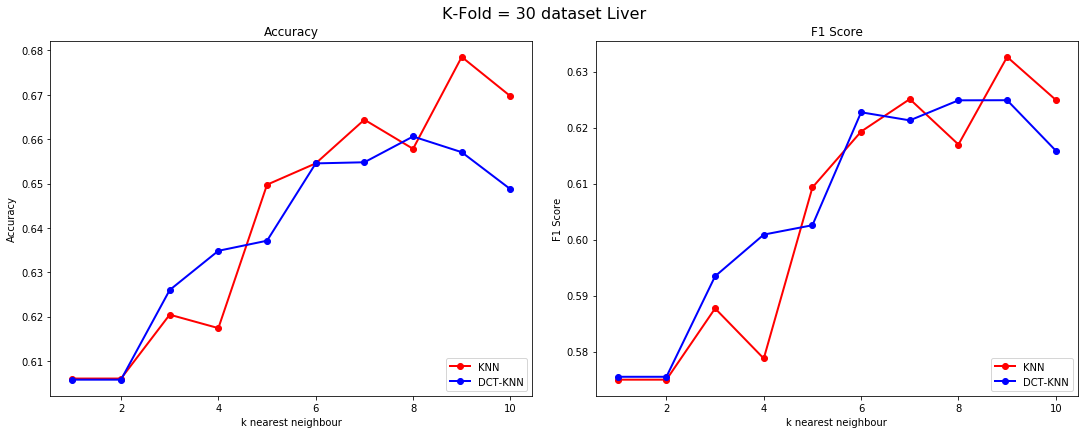

In [30]:
for K in K_yang_diujikan:
    KNN_accuracy_list = []
    KNN_f1_list = []
    DCTKNN_accuracy_list = []
    DCTKNN_f1_list = []
    pltplotvar = []
    
    for N in range (1, 11):
        knn_acc, knn_f1 = getKFold(X, Y, numberofK=K, numberofNeighbour=N, method="KNN")
        KNN_accuracy_list.append(knn_acc)
        KNN_f1_list.append(knn_f1)
        DCTKNN_acc,DCTKNN_f1 = getKFold(X, Y, numberofK=K, numberofNeighbour=N, method="DCT-KNN", weight = normalized_disc)
        DCTKNN_accuracy_list.append(DCTKNN_acc)
        DCTKNN_f1_list.append(DCTKNN_f1)
        pltplotvar.append(N)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
    fig.suptitle('K-Fold = ' + str(K) + ' dataset Liver', fontsize=16)
    
    axs[0].plot(pltplotvar,KNN_accuracy_list,'-ro', label="KNN", linewidth=2.0)
    axs[0].plot(pltplotvar,DCTKNN_accuracy_list,'-bo', label="DCT-KNN", linewidth=2.0)
    axs[0].legend(loc='lower right')
    axs[0].set_xlabel('k nearest neighbour')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Accuracy')
    
    axs[1].plot(pltplotvar,KNN_f1_list,'-ro', label="KNN", linewidth=2.0)
    axs[1].plot(pltplotvar,DCTKNN_f1_list,'-bo', label="DCT-KNN", linewidth=2.0)
    axs[1].legend(loc='lower right')
    axs[1].set_xlabel('k nearest neighbour')
    axs[1].set_ylabel('F1 Score')
    axs[1].set_title('F1 Score')
    
    plt.show()

